In [1]:
import pandas as pd,numpy as np
from glob import glob
import os,re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from multiprocessing import Pool

TE="RefL1_multi"

In [2]:
%%time

# Load the binned mC data. This was preprocessed in 01.gather_line1_mc
df=pd.read_csv(f'./binc_{TE}.mC.age_periods.tsv.gz',sep='\t',header=[0,1,2,3],index_col=[0,1],
#                nrows=10000
              )

# Remove "multi" from the RefL1_id
df.index.names=['RefL1_id','bin']
dfi = df.index.to_frame()
dfi['RefL1_id']=dfi['RefL1_id'].str.replace('_multi','')
dfi = pd.MultiIndex.from_frame(dfi)
df.index = dfi

CPU times: user 8.16 s, sys: 823 ms, total: 8.98 s
Wall time: 8.98 s


In [3]:
%%time
df_coverage=pd.read_csv(f'./binc_{TE}.coverage.age_periods.tsv.gz',sep='\t',header=[0,1,2,3],index_col=[0,1],
#                nrows=1000
              )

df_coverage=df_coverage.rename(columns=lambda x: x.replace('coverage-','m'))

CPU times: user 6.32 s, sys: 656 ms, total: 6.98 s
Wall time: 6.98 s


In [4]:
df.columns.names=['ctxt','mctype','sample','celltype']
df_coverage.columns.names=['ctxt','mctype','sample','celltype']

In [5]:
# Calculate hmC (BS-OxBS)
df=df.reorder_levels(['mctype','ctxt','sample','celltype'],axis=1)
df=pd.concat({'mC':df['OxBS'], 'hmC':df['BS']-df['OxBS']},axis=1,names=['mctype'])

In [6]:
for d in [df, df_coverage]:
  dfi=d.columns.to_frame()
  dfi['ctxt'] = dfi['ctxt']+'-'+dfi['mctype']
  dfi=dfi.drop(columns='mctype')
  d.columns=pd.MultiIndex.from_frame(dfi)


# Characterize the KNRGL loci

In [7]:
TE_bed=pd.read_csv(f'xtea_{TE}_all_KNRGL.bed',sep='\t',
                   names=['chr','start','end','strand','svlen','RefL1_ID','-','L1 class','5prime']
                  )

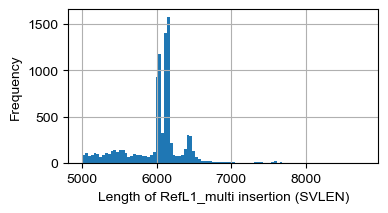

In [8]:
# TE_bed['TE_id']=TE_bed['TE_id_samples'].str.extract(f'({TE}_[0-9]+)')
# TE_bed['samples']=TE_bed['TE_id_samples'].str.extract(f'{TE}_[0-9]+:(.*)')

plt.figure(figsize=(4,2))
TE_bed['svlen'].plot(kind='hist',bins=100)
plt.xlabel(f'Length of {TE} insertion (SVLEN)')
plt.grid(True)

In [9]:
TE_bed['full length'] = (TE_bed['svlen']>200)&(TE_bed['svlen']<300)

In [10]:
l1_bed=pd.read_csv(f'xtea_{TE}_all_KNRGL.bed',sep='\t',
                   names=['chr', 'start', 'end', 'strand', 'evol_age', 'RefL1_id', 'score','L1 class','5prime'],
                  index_col='RefL1_id')
l1_bed.index = l1_bed.index.str.replace('_multi','')
l1_bed

chr      start        end strand  evol_age score L1 class  \
RefL1_id                                                                 
RefL1_0     chr1     440936     447357      +    6421.0     .    L1PA7   
RefL1_1     chr1     675912     682333      +    6421.0     .    L1PA7   
RefL1_2     chr1    4034646    4039971      +    5325.0     .    L1PB1   
RefL1_3     chr1    7411758    7417922      -    6164.0     .    L1PA4   
RefL1_4     chr1   14355445   14361840      -    6395.0     .    L1PA7   
...          ...        ...        ...    ...       ...   ...      ...   
RefL1_9956  chrX  155567854  155573980      +    6126.0     .    L1PA3   
RefL1_9957  chrX  155722806  155728823      -    6017.0     .    L1PA6   
RefL1_9958  chrX  155808795  155815006      +    6211.0     .    L1PA6   
RefL1_9959  chrX  155912364  155918771      -    6407.0     .    L1PA7   
RefL1_9960  chrX  155930718  155936823      -    6105.0     .    L1PA5   

               5prime  
RefL1_id               
RefL1_0        440936  
RefL1_1        675912  
RefL1_2       4034646  
RefL1_3       7417921  
RefL1_4      14361839  
...               ...  
RefL1_9956  155567854  
RefL1_9957  155728822  
RefL1_9958  155808795  
RefL1_9959  155918770  
RefL1_9960  155936822  

[9961 rows x 8 columns]

# Plot mC around reference L1 sites

In [11]:
%%time
# Coarse-grain the original bins (128bp)
binsize_show = 128
dfu=df.copy().reset_index('bin')
dfu['bin']=np.floor(dfu['bin']/binsize_show)*binsize_show
dfu=dfu.groupby(['RefL1_id','bin']).mean()

<timed exec>:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


CPU times: user 2.9 s, sys: 2.56 s, total: 5.46 s
Wall time: 5.43 s


In [12]:
%%time
# For each locus, calculate the mean signal for samples with TE and those without TE
dfu = dfu.stack(['ctxt','celltype'])
dfu_coverage=df_coverage.stack(['ctxt','celltype'])

CPU times: user 2.9 s, sys: 2.29 s, total: 5.19 s
Wall time: 5.19 s


In [13]:
%%time
# df.join(l1_bed,how='left')
dfu=dfu.reset_index().set_index('RefL1_id').join(l1_bed['L1 class'],how='left')
dfu=dfu.reset_index().set_index(['RefL1_id','bin','ctxt','celltype','L1 class'])

# dfu_coverage=dfu_coverage.reset_index().set_index('RefL1_id').join(l1_bed['L1 class'],how='left')
# dfu_coverage=dfu_coverage.reset_index().set_index(['RefL1_id','bin','ctxt','celltype','L1 class'])

CPU times: user 7.34 s, sys: 3.96 s, total: 11.3 s
Wall time: 11.3 s


In [78]:
# # Reduce the memory by restricting the window size
# keep = np.abs(dfu.index.get_level_values('bin').astype(int))<8000
# keep.sum(), keep.shape
# dfu = dfu.loc[keep,:]

In [79]:
# %%time
# dfu_A = dfu.filter(like='A').mean(axis=1)
# dfu_Y=dfu.filter(like='Y').mean(axis=1)
# dfu_mean =pd.concat((dfu_A,dfu_Y),axis=1,names=['Aged','Young'])
# dfu_mean.columns=['Aged','Young']

In [80]:
# dfu_mean.columns.names=['Age']
# dfu_mean=dfu_mean.stack()
# dfu_mean.head()

In [14]:
dfu_mean=dfu.groupby(['ctxt','celltype','L1 class','bin']).mean()

In [15]:
dfu_mean

adolescence     adult  early_child  \
ctxt     celltype L1 class bin                                            
mCGN-hmC GABA     L1HS     -12800.0     0.273045  0.287734     0.207937   
                           -12672.0     0.261041  0.264326     0.192367   
                           -12544.0     0.268560  0.292460     0.199361   
                           -12416.0     0.265991  0.280542     0.190352   
                           -12288.0     0.271217  0.287230     0.206790   
...                                          ...       ...          ...   
mCHN-mC  GLU      L1PREC2   12160.0     0.046553  0.043916     0.031801   
                            12288.0     0.045533  0.045635     0.031885   
                            12416.0     0.040672  0.039127     0.028749   
                            12544.0     0.039441  0.037921     0.026245   
                            12672.0     0.041059  0.038188     0.027404   

                                      infancy  late_adult  late_child  
ctxt     celltype L1 class bin                                         
mCGN-hmC GABA     L1HS     -12800.0  0.149604    0.302145    0.259828  
                           -12672.0  0.144359    0.274481    0.224875  
                           -12544.0  0.155928    0.292338    0.248826  
                           -12416.0  0.141494    0.282655    0.246233  
                           -12288.0  0.156743    0.298246    0.268416  
...                                       ...         ...         ...  
mCHN-mC  GLU      L1PREC2   12160.0  0.018487    0.050339    0.043235  
                            12288.0  0.017415    0.047679    0.041595  
                            12416.0  0.017265    0.041400    0.035293  
                            12544.0  0.017345    0.042041    0.035516  
                            12672.0  0.016896    0.042165    0.035100  

[110203 rows x 6 columns]

In [16]:
l1_classes=dfu.index.get_level_values('L1 class').unique()
# l1_classes=['L1PA7', 'L1PA5', 'L1PB4', 'L1HS', 'L1PA10', 'L1PA6', 'L1PA2']

In [17]:
rmsk = pd.read_csv('rmsk_hg38.L1.gtf',sep='\t',names=['chr','.','exon','start','end','evolutionary age','strand','-','info'])
rmsk['L1 class']=rmsk['info'].str.extract('gene_id \"(.*)\"; transcript_id')
rmsk=rmsk[rmsk['L1 class'].isin(l1_classes)]
L1_order=rmsk.groupby('L1 class')['evolutionary age'].mean().sort_values().index[::-1]
L1_order=L1_order[:20]

CPU times: user 1.89 s, sys: 313 ms, total: 2.21 s
Wall time: 1.87 s


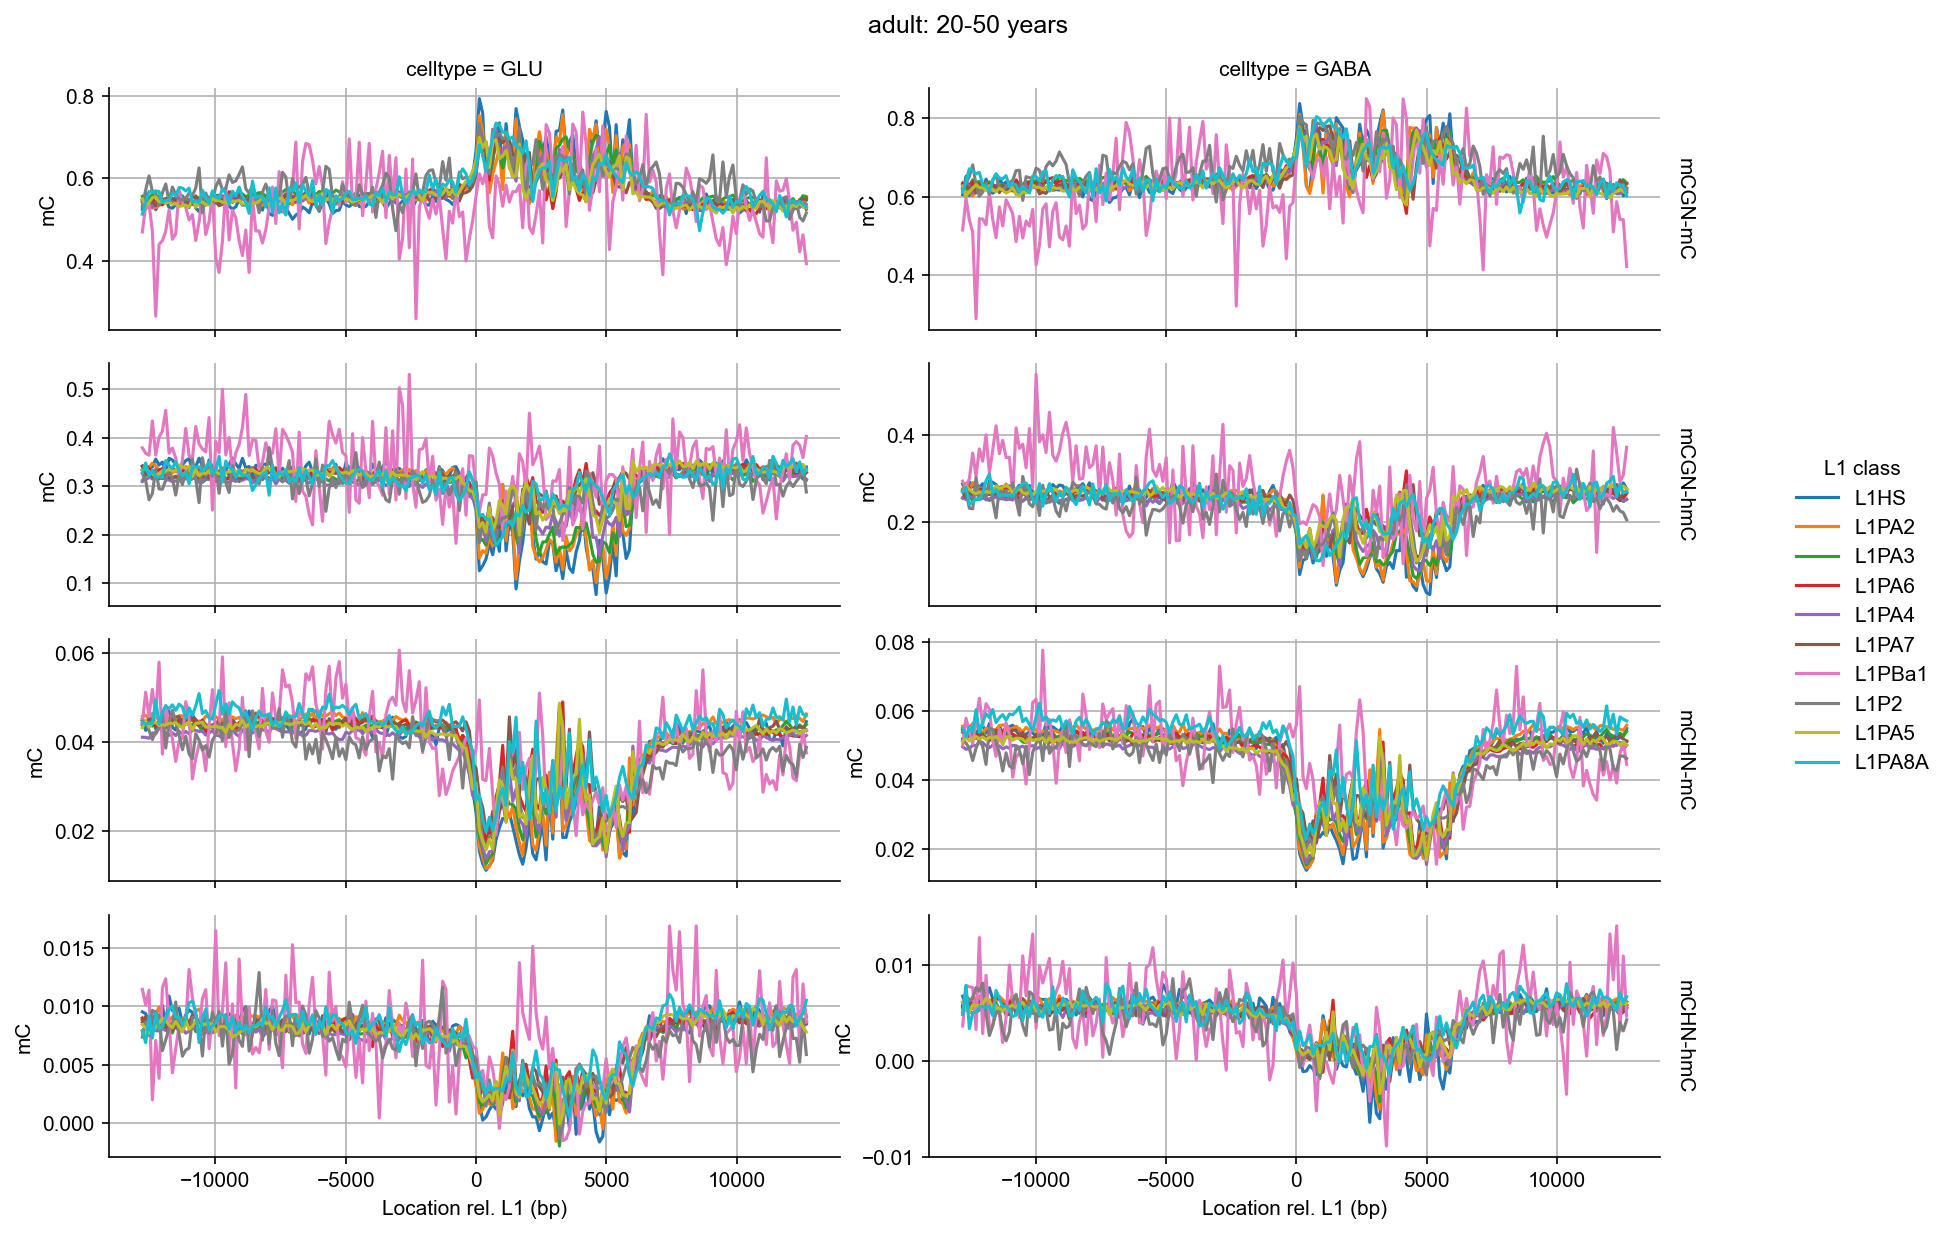

In [52]:
%%time
age_periods = {'infancy':[0,1], 'early_child':[1,5],'late_child':[5,12],'adolescence':[12,20],'adult':[20,50],'late_adult':[50,200]}

# Line plots of mean mC in bins around the L1 sites
age = 'adult'
g=sns.relplot(dfu_mean.reset_index(),x='bin',y=age,kind='line',
            hue='L1 class',
              hue_order=L1_order[:10],
            row='ctxt',row_order=['mCGN-mC','mCGN-hmC','mCHN-mC','mCHN-hmC'],
            col='celltype',
              col_order=['GLU','GABA'],
            facet_kws={'sharey':False,'margin_titles':True,},
            height=2,aspect=3,
#        'L3-5IT_RORB_PLCH1', 'L4-5IT_RORB_ARHGAP15','CGE_ADARB2_ADAM33','MGE_PVALB', 'MGE_SST',]
           )
g.set_titles(row_template='{row_name}')
g.tight_layout()
g.fig.suptitle(f'{age}: {age_periods[age][0]}-{age_periods[age][1]} years',y=1.02)
[ax.set_xlabel('Location rel. L1 (bp)') for ax in g.axes.flatten()]
[ax.set_ylabel('mC') for ax in g.axes.flatten()]
[ax.grid(True) for ax in g.axes.flatten()];
g.fig.set_dpi(150)

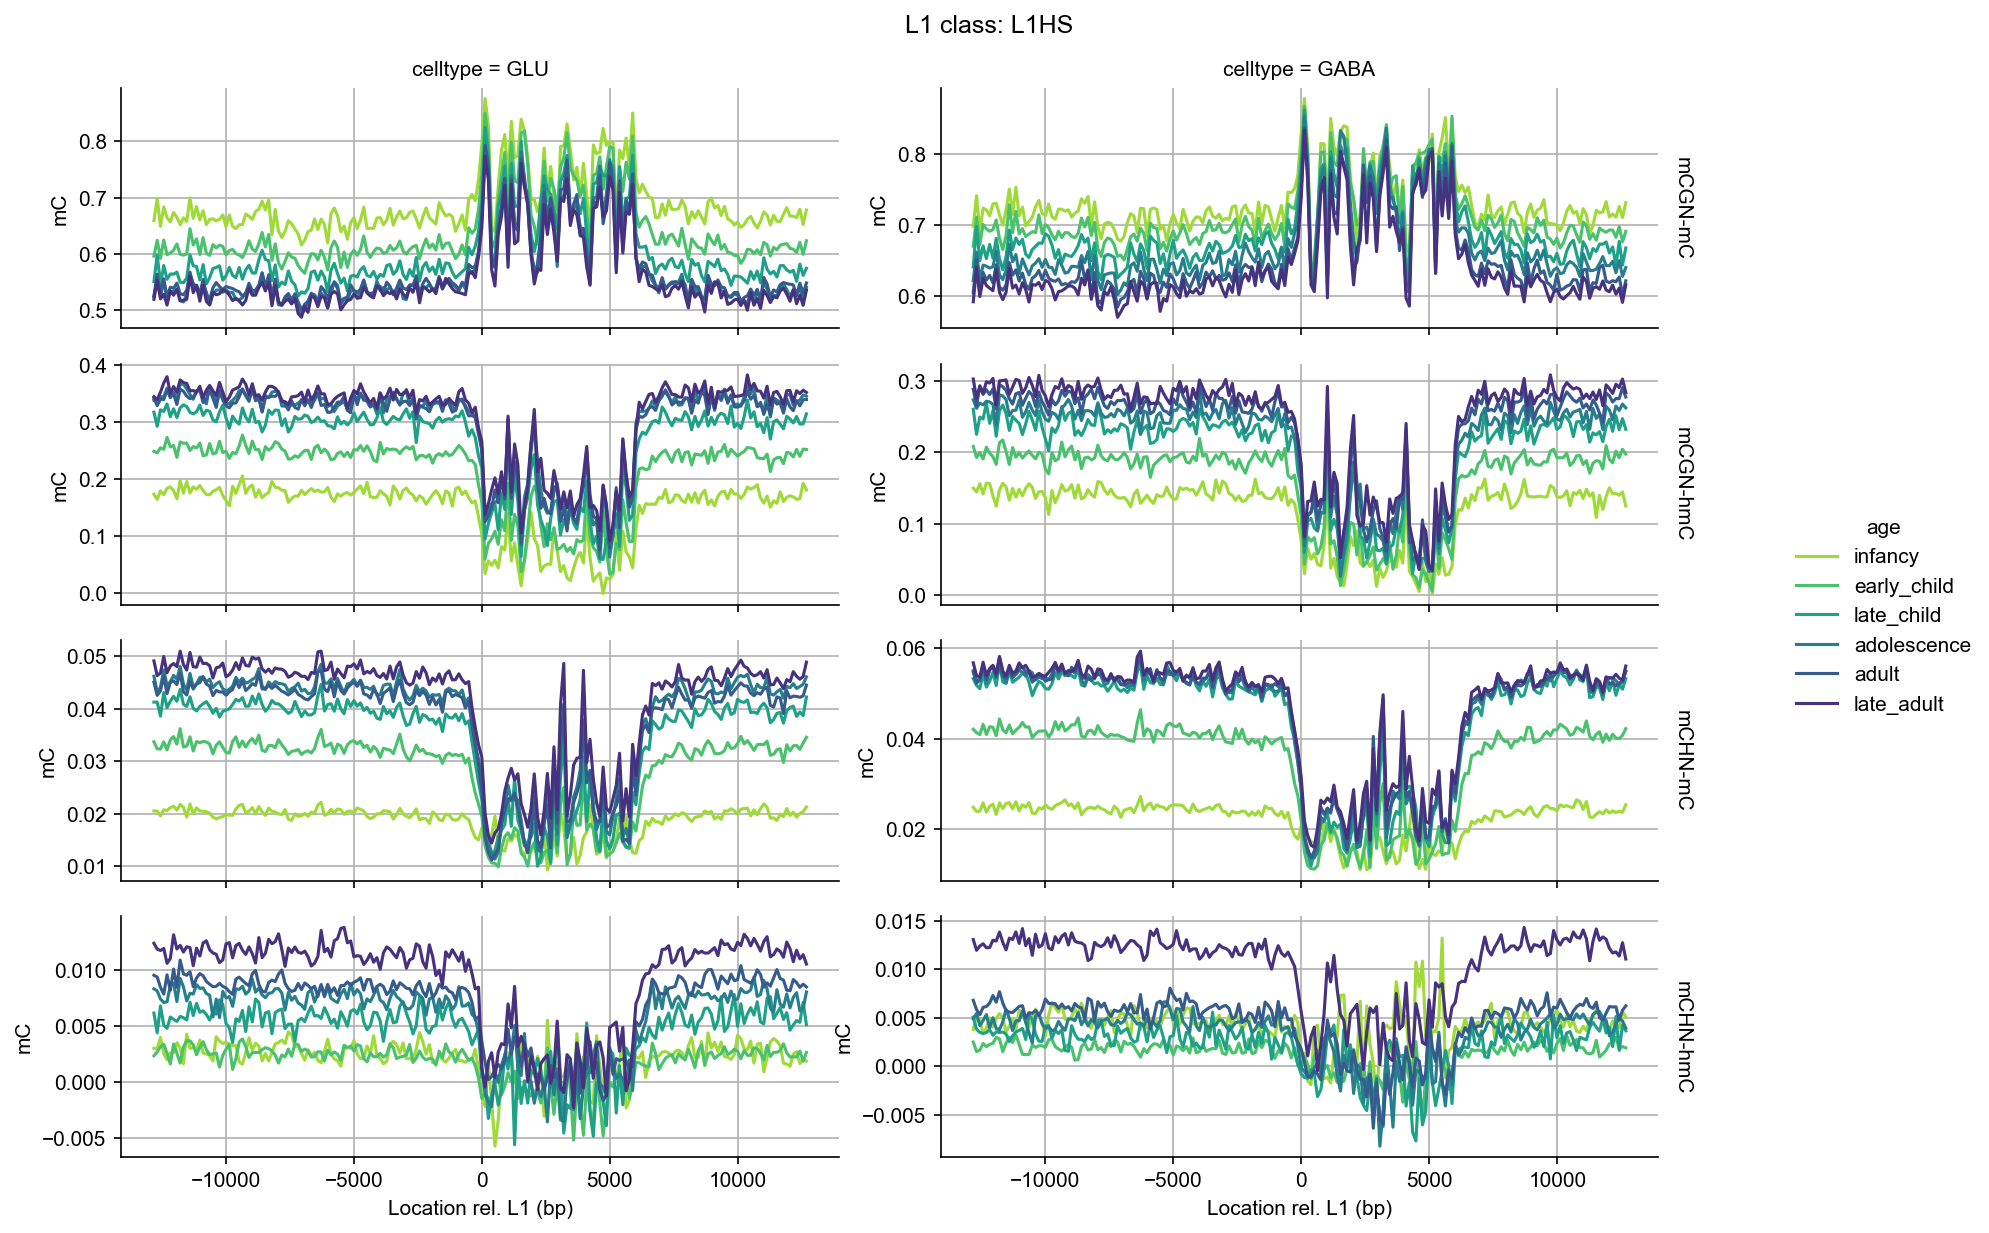

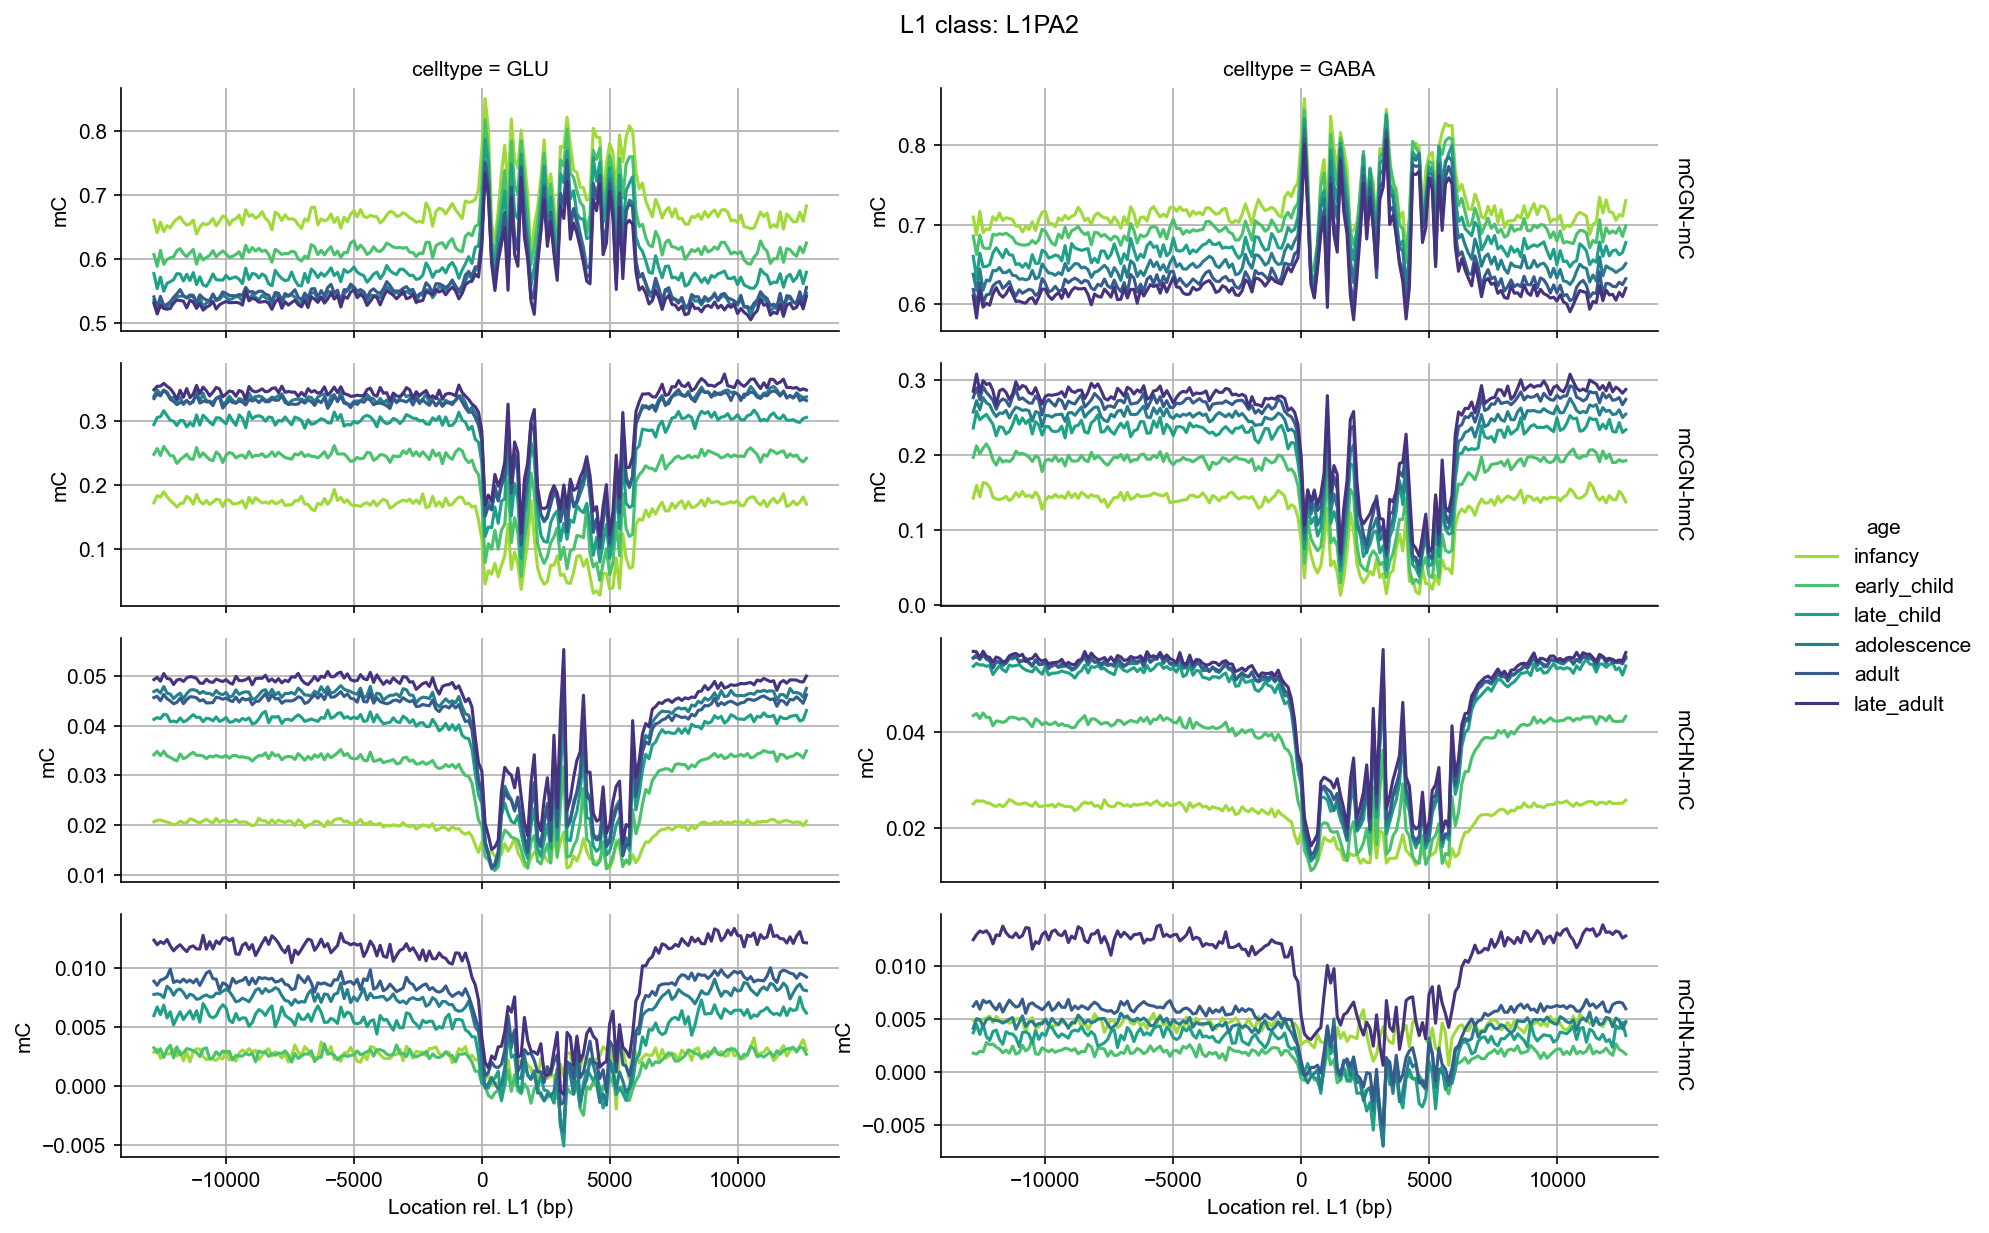

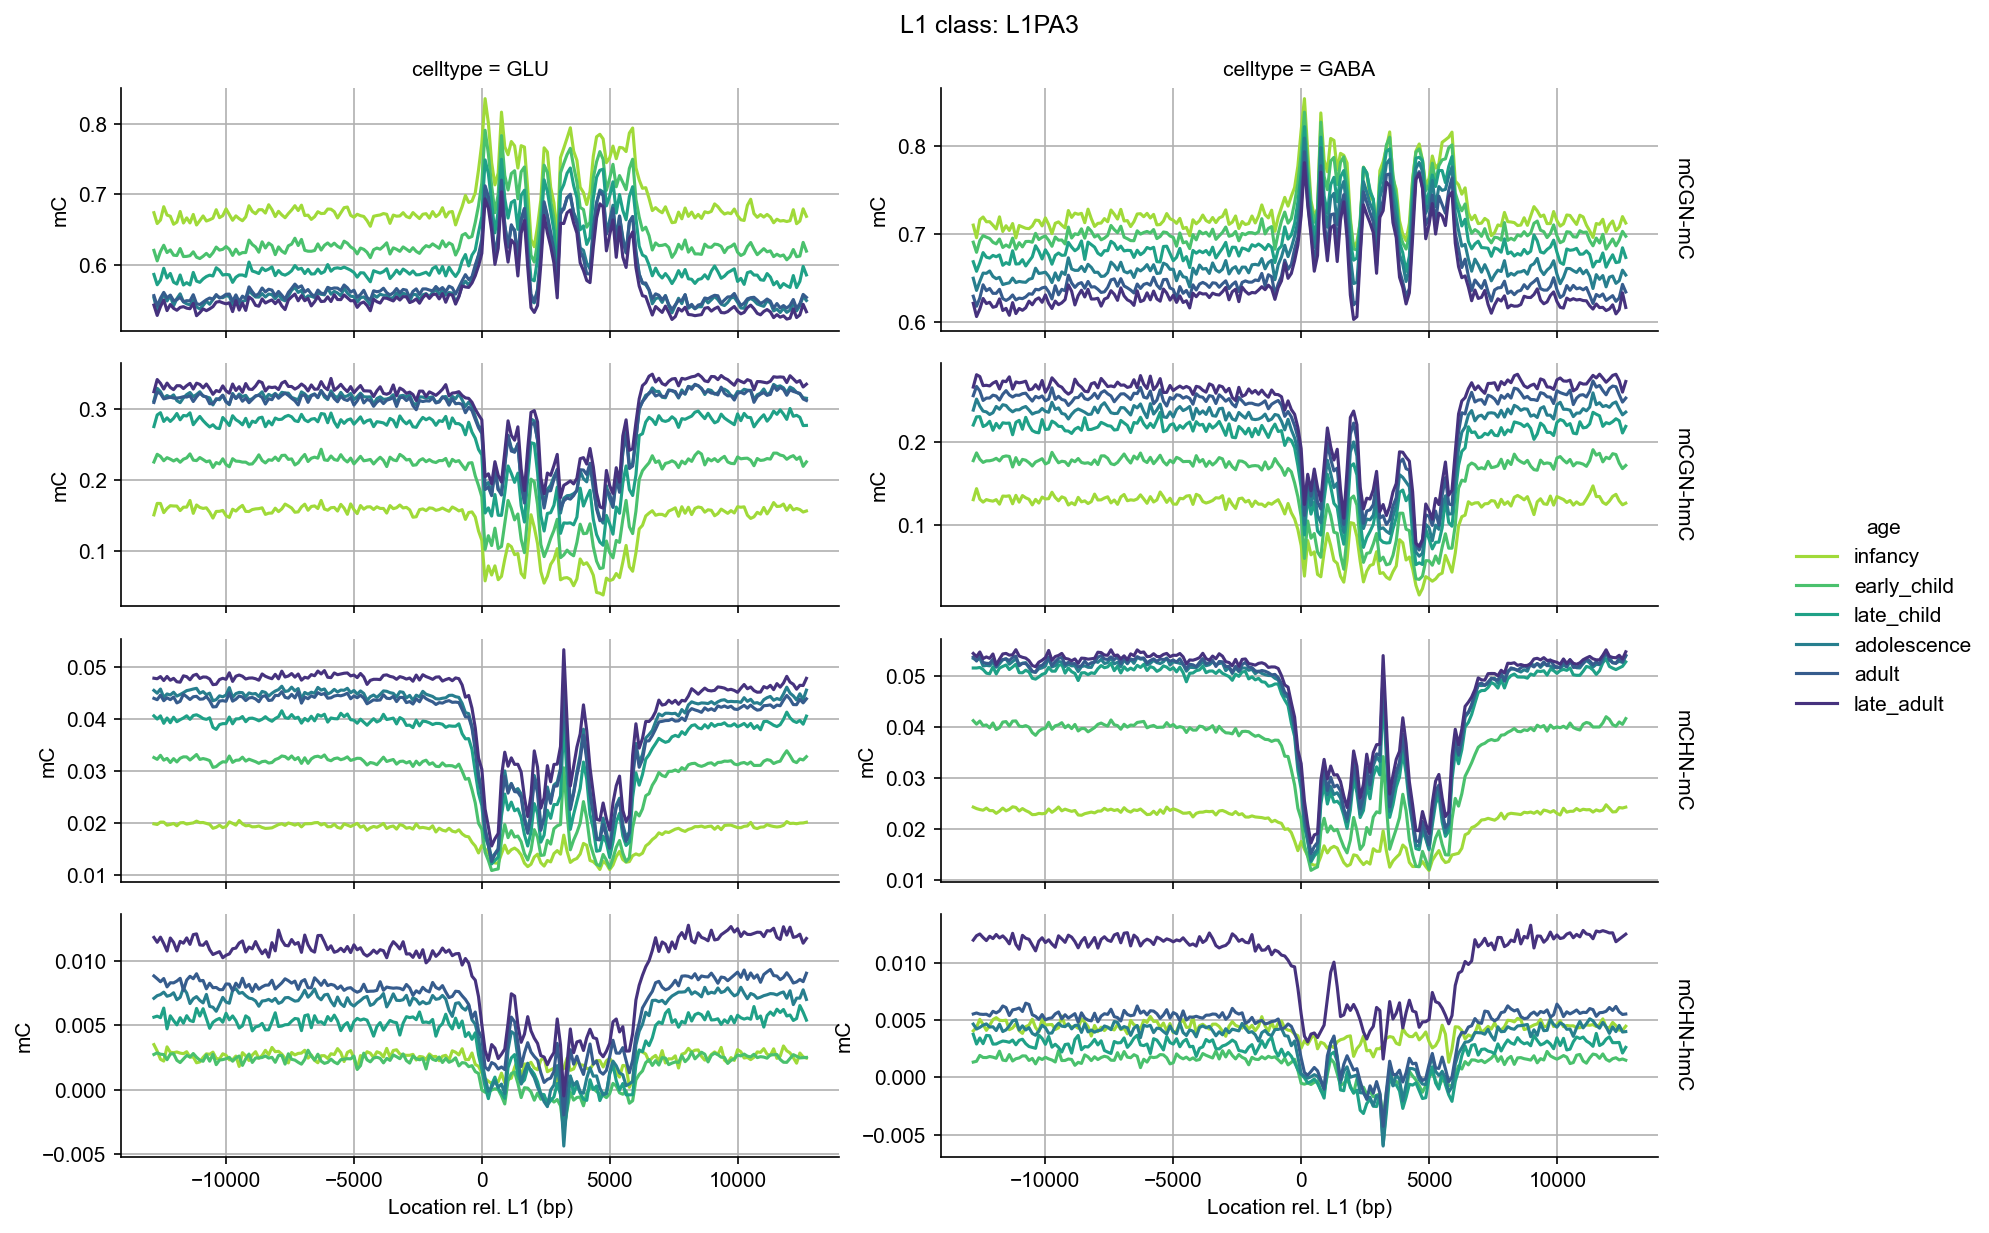

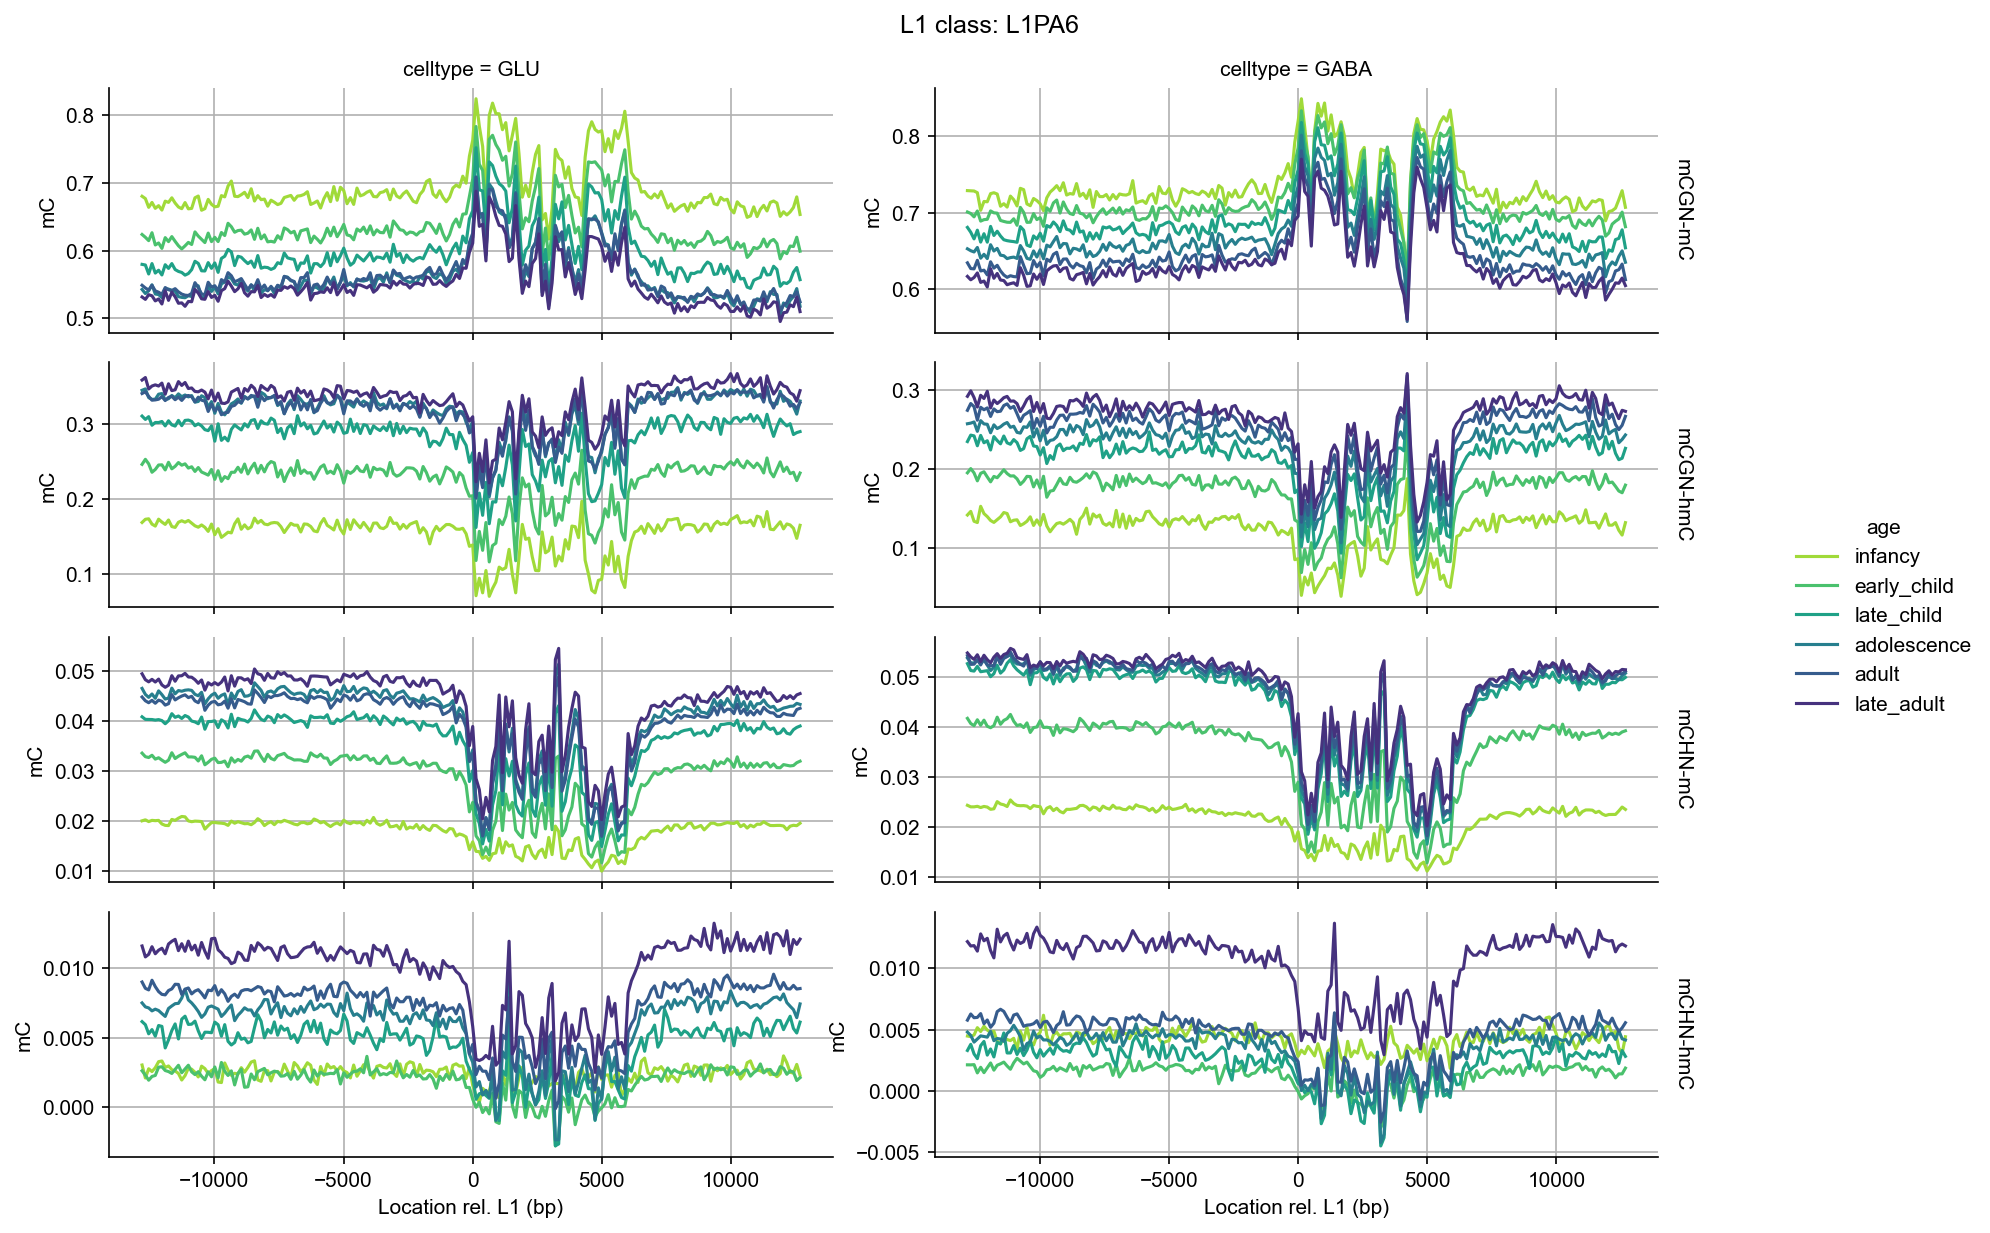

In [57]:
for class_show in L1_order[:1]:
  dfu_show=dfu_mean.stack()
  dfu_show.index.names=['ctxt', 'celltype', 'L1 class', 'bin', 'age']
  dfu_show.name='mC'
  dfu_show=dfu_show.loc[(slice(None),slice(None),class_show)].reset_index()

  g=sns.relplot(dfu_show,
                x='bin',y='mC',kind='line',
              hue='age',
                hue_order=age_periods.keys(),
              row='ctxt',row_order=['mCGN-mC','mCGN-hmC','mCHN-mC','mCHN-hmC'],
              col='celltype',
                col_order=['GLU','GABA'],
              facet_kws={'sharey':False,'margin_titles':True,},
              height=2,aspect=3,
                palette='viridis_r',
  #        'L3-5IT_RORB_PLCH1', 'L4-5IT_RORB_ARHGAP15','CGE_ADARB2_ADAM33','MGE_PVALB', 'MGE_SST',]
             )
  g.set_titles(row_template='{row_name}')
  g.tight_layout()
  g.fig.suptitle(f'L1 class: {class_show}',y=1.02)
  [ax.set_xlabel('Location rel. L1 (bp)') for ax in g.axes.flatten()]
  [ax.set_ylabel('mC') for ax in g.axes.flatten()]
  [ax.grid(True) for ax in g.axes.flatten()];
  g.fig.set_dpi(150)

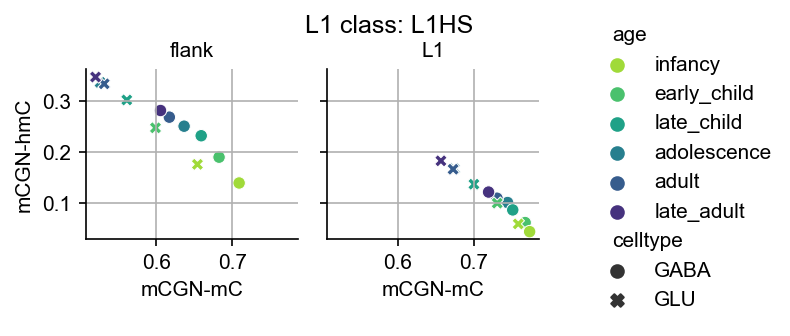

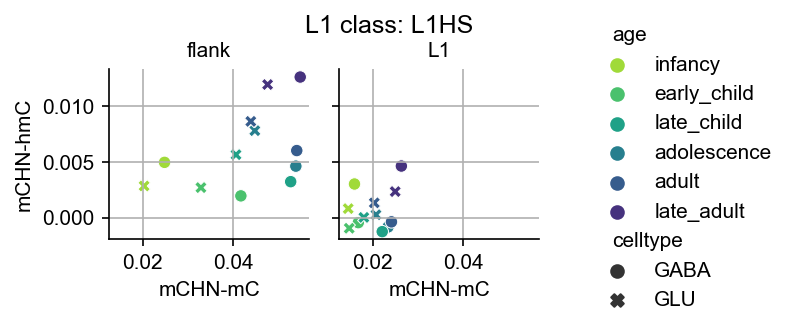

In [82]:
class_show='L1HS'
dfu_show=dfu_mean.stack()
dfu_show.index.names=['ctxt', 'celltype', 'L1 class', 'bin', 'age']
dfu_show.name='mC'
dfu_show=dfu_show.loc[(slice(None),slice(None),class_show)].reset_index()

dfu_show['region'] = pd.cut(dfu_show['bin'], [-10000,-5000,0,6000], labels=['flank','upstream','L1'])
dfu_show=dfu_show.groupby(['region','ctxt','celltype','age',])['mC'].mean()
dfu_show=dfu_show.unstack('ctxt')

for ctxt in ['CG','CH']:
  g=sns.relplot(data=dfu_show,
              x=f'm{ctxt}N-mC',y=f'm{ctxt}N-hmC',
              kind='scatter',
              col='region',col_order=['flank','L1'],
  #             col='celltype',
              style='celltype',
                linestyle='-',
              height=2,aspect=1,
                facet_kws={'margin_titles':True,},
              hue='age',hue_order=age_periods.keys(),palette='viridis_r')
  g.set_titles(row_template='{row_name}',col_template='{col_name}')
  g.tight_layout()
  g.fig.suptitle(f'L1 class: {class_show}',y=1.02)
  [ax.grid(True) for ax in g.axes.flatten()];
  g.fig.set_dpi(150)


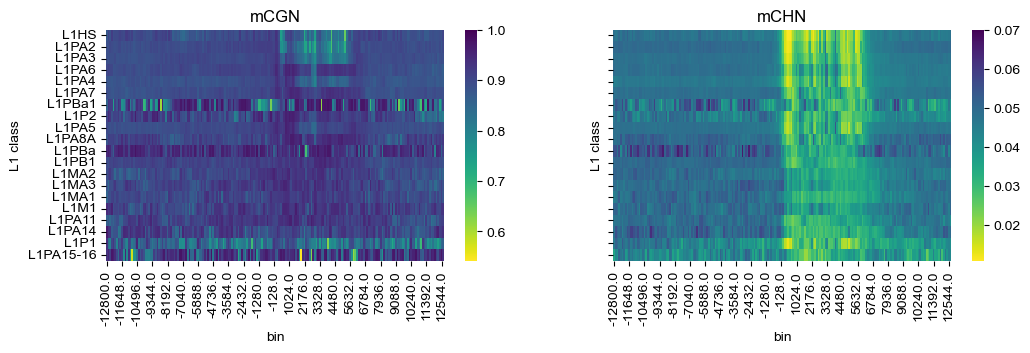

In [149]:
L1_order=rmsk.groupby('L1 class')['evolutionary age'].mean().sort_values().index[::-1]
# L1_order=L1_order[:15]
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,3))
for ctxt,ax,vmax in zip(['mCGN','mCHN'],axs,[1,0.07]):
  sns.heatmap(dfu_mean[(ctxt,'L2-4IT_CUX2')].unstack('bin').loc[L1_order[:20]],
  #             vmin=.6,vmax=1
              vmax=vmax,
              yticklabels=True,
              cmap='viridis_r',
              ax=ax)
  ax.set_title(ctxt)


In [118]:
df_show=dfu_mean.loc[(slice(None),'L2-4IT_CUX2')]

CPU times: user 6.8 s, sys: 243 ms, total: 7.04 s
Wall time: 6.71 s


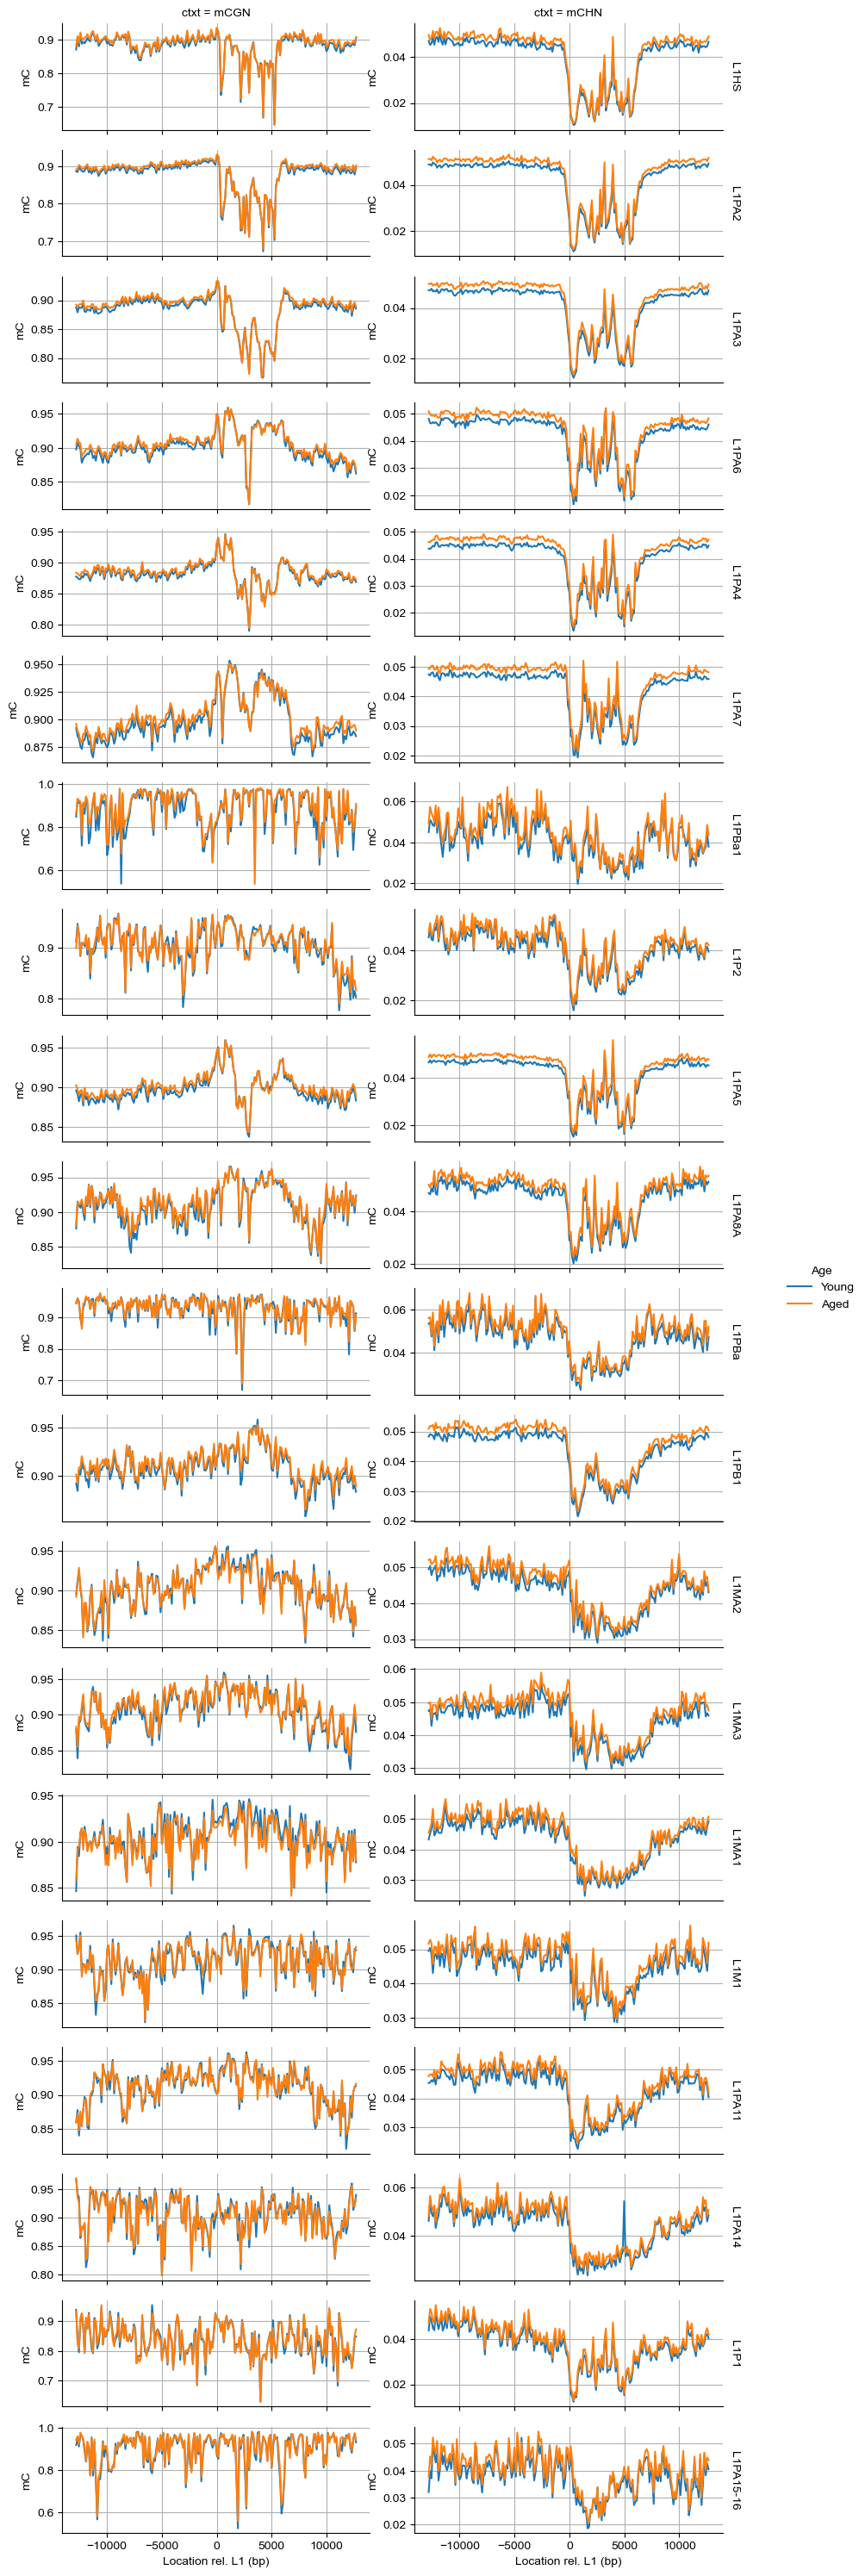

In [123]:
%%time
# Line plots of mean mC in bins around the L1 sites
g=sns.relplot(df_show.reset_index(),x='bin',y=0,kind='line',
            hue='Age',
              hue_order=['Young','Aged'],
            col='ctxt',
            row='L1 class',
              row_order=L1_order,
#               row_order=['L2-4IT_CUX2',
#                                       'MGE_SST', 'L4-5IT_RORB_ARHGAP15'
#                                      ],
            facet_kws={'sharey':False,'margin_titles':True,},
            height=1.5,aspect=3,
#        'L3-5IT_RORB_PLCH1', 'L4-5IT_RORB_ARHGAP15','CGE_ADARB2_ADAM33','MGE_PVALB', 'MGE_SST',]
           )
g.set_titles(row_template='{row_name}')
g.tight_layout()
[ax.set_xlabel('Location rel. L1 (bp)') for ax in g.axes.flatten()]
[ax.set_ylabel('mC') for ax in g.axes.flatten()]
[ax.grid(True) for ax in g.axes.flatten()];

In [ ]:
def show_heatmap(data,**kws):
#   df_show=dfu_mean.loc[(ctxt,celltype,slice(None),slice(None))].unstack('bin')
#   df_show=df_show.loc[L1_order,:]

  df_show = data.set_index(['bin','L1 class']).iloc[:,-1].unstack('bin')
  df_show=df_show.sort_index(axis=1)
  ax=plt.gca()
  sns.heatmap(data=df_show,
              ax=ax,
#               vmax=0,
#               vmin=0,
              yticklabels=True,**kws)

In [ ]:
dfu_show=dfu_mean.reset_index()
dfu_show=dfu_show[dfu_show['L1 class'].isin(L1_order)]

g=sns.FacetGrid(data=dfu_show,
                row='celltype',col='ctxt',
                row_order=['L2-4IT_CUX2',
       'L3-5IT_RORB_PLCH1', 'L4-5IT_RORB_ARHGAP15','CGE_ADARB2_ADAM33','MGE_PVALB', 'MGE_SST',]
               )
g.map_dataframe(show_heatmap)

In [ ]:
sns.relplot(data=df_show.T,kind='line',legend=True)

In [ ]:
dfu_TE = dfu[[TE,f'No{TE}',
              f'Coverage-{TE}',f'Coverage-No{TE}'
             ]].dropna()
nshow = dfu_TE.index.get_level_values(f'{TE}_id').nunique()

In [ ]:
%%time
# Coarse-grain the original bins (128bp)
binsize_show = 128

dfu_TE_show=dfu_TE.copy()
dfu_TE_show=dfu_TE_show.stack().reset_index().rename(columns={0:'mC','sample':f'{TE} status'})
dfu_TE_show['bin_resample']=np.floor(dfu_TE_show['bin']/binsize_show)*binsize_show
dfu_TE_show_median = dfu_TE_show.groupby(['bin_resample',f'{TE} status','celltype','ctxt'])[['mC']].median()
dfu_TE_show_mean = dfu_TE_show.groupby(['bin_resample',f'{TE} status','celltype','ctxt'])[['mC']].mean()

In [ ]:
# Calculate the difference between Alu and NoAlu
dfu_TE_show_mean=dfu_TE_show_mean.unstack(f'{TE} status')
dfu_TE_show_mean[('mC','Diff')]=dfu_TE_show_mean[('mC',TE)]-dfu_TE_show_mean[('mC',f'No{TE}')]
dfu_TE_show_mean=dfu_TE_show_mean.stack(f'{TE} status')

dfu_TE_show_median.index=dfu_TE_show_median.index.reorder_levels([f'{TE} status','celltype','ctxt','bin_resample'])
dfu_TE_show_mean.index=dfu_TE_show_mean.index.reorder_levels([f'{TE} status','celltype','ctxt','bin_resample'])

In [ ]:
dfu_TE_show_mean

In [ ]:
%%time
g=sns.relplot(dfu_TE_show_mean.loc[[TE,f'No{TE}']],kind='line',
# g=sns.relplot(dfu_TE_show,
              x='bin_resample',y='mC',
#               hue='celltype',style=f'{TE} status',
              hue=f'{TE} status',palette={TE:'r',f'No{TE}':'k'},
              height=2,aspect=3,row='ctxt',
              legend=True,
              facet_kws={'sharey': False, 'sharex': True},
              errorbar=('ci',95)
             )
[ax.grid(True) for ax in g.axes.flatten()]
g.fig.suptitle(f'Average over {TE} insertions ({nshow} events)',y=1.02)

In [ ]:
plt.xlim([-8e3,8e3])
plt.savefig(f'Plots/mC_profile_{TE}_lineplots.pdf')

In [ ]:
# g.fig.suptitle(f'Average over full length insertions ({TE_bed.shape[0]} events)',y=1.02)
# g.fig

In [ ]:
for xl in [5000,1000]:
  g.axes[0,0].set_xlim([-xl,xl])
  g.fig.savefig(f'Plots/KNRGL_{TE}_mean_mC_ErrorBars_xlim{xl//1000}kbp.pdf')

In [ ]:
celltypes=dfu_TE_show_mean.reset_index()['celltype'].unique()
cellclass = {c:'Exc' for c in celltypes if c[0]=='L'}
cellclass.update({c:'Glia' for c in celltypes if 'Glia' in c})
cellclass.update({c:'Inh' for c in celltypes if 'CGE' in c or 'MGE' in c})
palette = {'Exc':'g','Inh':'r','Glia':'gray'}

In [ ]:
dfu_TE_show_mean['cell class']=dfu_TE_show_mean.index.get_level_values('celltype').map(cellclass)
dfu_TE_show_mean=dfu_TE_show_mean.reset_index().set_index([f'{TE} status','celltype','ctxt','cell class','bin_resample'])

In [ ]:
dfu_TE_show_mean_mean = dfu_TE_show_mean.groupby([f'{TE} status','ctxt','cell class','bin_resample']).mean()

In [ ]:
# Separate lineplots for each celltype
g=sns.relplot(100*dfu_TE_show_mean_mean.loc['Diff'],kind='line',
              x='bin_resample',y='mC',
              hue='cell class',
#               palette=palette,
              height=2,aspect=3,row='ctxt',
              legend=True,palette=palette,hue_order=['Exc','Inh','Glia'],
             facet_kws={'sharey': False, 'sharex': True})
[ax.grid(True) for ax in g.axes.flatten()]
[ax.set_ylabel(f'Difference in %mC\n({TE} - No TE)') for ax in g.axes.flatten()]
plt.xlim([-1e4,1e4])
g.fig.suptitle(f'Average over {TE} insertions ({nshow} events)',y=1.02)

In [ ]:
dfu_TE_show_mean

In [ ]:
%%time
g=sns.relplot(dfu_TE_show_mean.loc[[f'Coverage-{TE}',f'Coverage-No{TE}']],kind='line',
              x='bin_resample',y='mC',
#               hue='celltype',style=f'{TE} status',
              hue=f'{TE} status',palette={f'Coverage-{TE}':'r',f'Coverage-No{TE}':'k'},
              height=2,aspect=3,row='ctxt',col='cell class',legend=True,
              facet_kws={'sharey': False, 'sharex': True},
              errorbar=('ci',95)
             )
[ax.grid(True) for ax in g.axes.flatten()]
[ax.set_ylabel('Coverage') for ax in g.axes.flatten()]
for xl in [8000]:
  g.axes[0,0].set_xlim([-xl,xl])
  g.fig.savefig(f'Plots/KNRGL_{TE}_mean_Coverage_ErrorBars_xlim{xl//1000}kbp.pdf')

In [ ]:
[ax.set_ylabel('Coverage (C basecalls)') for ax in g.axes.flatten()]
g.axes[0,0].set_xlim([-10000,10000])
g.fig.savefig('Plots/KNRGL_mean_Coverage_ErrorBars.pdf')
g.fig


In [ ]:
neuron_types=['CGE_ADARB2_ADAM33', 'CGE_LAMP5', 'CGE_LAMP5_LHX6', 'CGE_VIP',
       'L2-4IT_CUX2', 'L3-5IT_RORB_PLCH1',
       'L4-5IT_RORB_ARHGAP15', 'L4-5IT_RORB_LRRK1', 'L4-5IT_RORB_TSHZ2',
       'L56NP_TLE4_TSHZ2', 'L6CT_TLE4_FAM95C', 'L6IT_THEMIS_CUX1',
       'L6IT_THEMIS_LINC00343', 'L6b_TLE4_NXPH4', 'MGE_PVALB', 'MGE_SST',
       'MGE_SST_CLMP', 'CGE_PAX6']

In [ ]:
dfu_TE_show['bin_resample']=dfu_TE_show['bin_resample'].astype(int)

# df_curr= dfu_TE_show[dfu_TE_show['bin_resample']==-1024].groupby(['ctxt','celltype',f'{TE} status','TE_id'])[['mC']].mean()
df_curr= dfu_TE_show[(dfu_TE_show['bin_resample']<=1500)&(dfu_TE_show['bin_resample']>=-1500)]
df_curr = df_curr.loc[(df_curr['bin']%512)==0]
df_curr['cell class']=df_curr['celltype'].map(cellclass)

df_curr=df_curr.groupby(['ctxt','cell class','bin_resample',f'{TE} status',f'{TE}_id',])['mC'].mean()

# df_curr=df_curr.loc[('mCHN',neuron_types),:]['mC']
# df_curr['bin_resample']=df_curr['bin_resample'].astype(str)
# df_curr=df_curr.set_index([f'{TE} status','bin_resample','TE_id'])
df_curr=df_curr.unstack(f'{TE} status')

df_curr['diff']=df_curr[TE]-df_curr[f'No{TE}']
# df_curr['diff']=(df_curr[TE]+.01)/(df_curr[f'No{TE}']+.01)
df_curr=df_curr.loc['mCHN']

In [ ]:
df_curr=df_curr.groupby([f'{TE}_id','cell class','bin_resample']).mean()

In [ ]:
sns.boxplot(data=df_curr.reset_index(['bin_resample','cell class']),x='bin_resample',y='diff',fliersize=0,hue='cell class',
           hue_order=['Exc','Inh'])
plt.xticks(rotation=90);
plt.ylim([0,2])

In [ ]:
# Scatter plots for each bin relative to the L1 location
g=sns.relplot(data=df_curr,
            x=TE,y=f'No{TE}',
#             kind='point',native_scale=True,
#             row='celltype',
            col='bin_resample',
              row='cell class',
              row_order=['Exc','Inh','Glia'],
              height=2,s=2,hue='cell class',palette=palette,
#             facet_kws={'sharey': False, 'sharex': False},
           )
g.set_titles(template="bin={col_name}bp")
plt.xlim([0,.2])
[ax.plot(ax.get_xlim(),ax.get_xlim(),'k--') for ax in g.axes.flatten()];
[ax.grid(True) for ax in g.axes.flatten()];

In [ ]:
interesting_TEs=df_curr.loc[(slice(None),'Exc',0)].sort_values('diff').index[:10]
TE_bed[TE_bed['TE_id'].isin(interesting_TEs)]

In [ ]:
# dfu.loc[locus,TE]=np.nanmean(dfu.loc[locus,pos_samples],axis=1)
# dfu.loc[locus]
dfu.loc[locus,pos_samples].mean(axis=1)
dfu.loc[locus,TE]

In [ ]:
df_diffs=[]
for locus in loci_show:
  # dfu=df.loc[:,(ctxt_show,slice(None),celltypes_show)]
  dfu=group_samples(locus,
                    df,
                    TE_bed)

  dfu=dfu.reorder_levels(['has_TE','ctxt','celltype'],axis=1)
  dfu_diff=dfu[f'No{TE}']-dfu[TE]
  dfu_diff['TE_id']=locus
  dfu_diff=dfu_diff.reset_index().set_index(['bin','TE_id'])
  break
dfu_diff

In [ ]:
for a in dfu:
  print(a)

In [ ]:
hl

In [ ]:
TE_bed[TE_bed['TE_id']==locus]

In [ ]:
loci_show

In [ ]:
def plot_mc(df,
            locus,
            TE_bed=TE_bed,
            celltypes_show = ['L4-5IT_RORB_TSHZ2', 'L4-5IT_RORB_LRRK1','L2-4IT_CUX2'],
            ctxt_show=['mCGN'],
            yspace=1):

#   dfu=df.loc[:,(ctxt_show,slice(None),celltypes_show)]
  
  dfu=group_samples(locus,df,TE_bed)
  locus_info=TE_bed[TE_bed['TE_id']==locus].iloc[0]
  
  # Make a plot showing the mC level for each cell type for L1 vs. no-L1
  fig,axs=plt.subplots(1,len(ctxt_show),squeeze=False)
  hl={}
  for ax,ctxt in zip(axs.flatten(),ctxt_show):
    for j,celltype in enumerate(celltypes):
      for color,l1 in zip(['r','k'],[TE,f'No{TE}']):
        dfuu=dfu.loc[:,(ctxt,l1,celltype)]
        hl[l1]=ax.plot(dfuu+j*yspace,color=color,label=l1)
    ax.set_ylabel('Celltypes')
    ax.set_yticks(np.arange(len(celltypes))*yspace+yspace/2,labels=celltypes)
    ax.grid(axis='x')
    ax.set_xlim([dfuu.index.min(),dfuu.index.max()])
    ax.set_title(locus_info['TE_id']+': '+locus_info['samples']+
                 f'\n{locus_info["chr"]}:{locus_info["start"]}-{locus_info["end"]} {locus_info["strand"]}')

    ax.legend(hl[TE]+hl[f'No{TE}'],[TE,f'No{TE}'])
    
  return axs

axs=[]
for i,locus in enumerate(loci_show.iloc[:10]):
  ax=plot_mc(df,locus)
  axs.append(ax)


In [ ]:
%%time
dfu=dfu.stack(['ctxt','celltype','has_TE']).reset_index().rename(columns={0:'mC'})
g=sns.relplot(dfu, 
            x='bin',y='mC',
            kind='line',
            col='celltype',col_wrap=4,
            hue='has_TE',palette={TE:'r',f'No{TE}':'k'},
            height=3
           )
[ax.grid(True) for ax in g.axes]

In [ ]:
x=dfu.columns.to_frame()
x['ctxt']='asdf'
dfu.columns=pd.MultiIndex.from_frame(x)
dfu

In [ ]:
celltypes